In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Fetch Dataset 

In [28]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

data_path = "../../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26
#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))


ind = int(0.8 * len(index))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])



s_triu = extract_triu_batch(S, dim)
p_triu = extract_triu_batch(P, dim)

s_triu_norm, mu, std = AbstractDataset.normalize(s_triu)


s_train, p_train, s_test, p_test = split(s_triu_norm, p_triu, ind)

# Pure blocks

i will now set all other elements zero

## Utilities

In [3]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[0][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS["sto-3g"][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

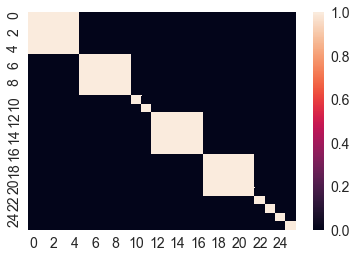

In [4]:
import seaborn as sns

sns.heatmap(mask.astype("int"))

In [21]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def extract_pure(p):
    p_batch = reconstruct_from_triu(p.copy(), dim)
    p_batch[np.logical_not(mask)] = 0
    return p_batch

p_pure = np.array(list(map(extract_pure, p_test)))

24.212545728814572
24.410768763940176
23.987858996648157
24.14694580504477
23.977075356676863
24.40337644546618
24.185445816445206
24.554179760754717
23.934548225079674
24.552651313221386
24.016483305825346
24.62508932082673
24.306546690556114
24.139027968608367
24.667259697718976
23.59610568221026
24.13913336900055
23.681255366672897
24.584176245715188
24.120994056766314
24.41228095131245
24.17697413100745
24.67327010146732
24.39977797863854
23.670976529236018
23.949641731905462
24.76769962480759
24.320078385843406
24.75496699459195
23.930710724553382
24.228930784788187
24.057538949811853
24.457279736797084
23.609614853839794
24.335453676498926
24.740071035380044
23.74358133463789
24.00468024797033
24.118812797339345
23.80438499933013
24.480763363474587
24.110603246063643
24.02407738155148
24.519695703073307
23.845821148218903
24.132769375865458
24.147406348989808
24.335881490295506
24.187335693300664
23.900328963713296
23.93774952206882
24.228656389160044
24.27226182236633
23.9060651

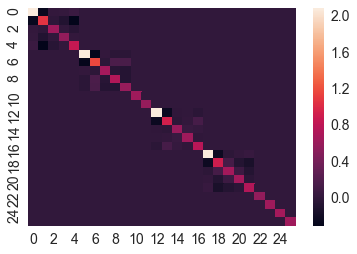

In [6]:
sns.heatmap(p_pure[0])

In [7]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

N_ELECTRONS = 30

dataset = StaticDataset(
    train=(s_train, p_train),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)


## Pure Block Analysis 

In [8]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer


print(make_results_str(measure_all_quantities(
    p_pure,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=True,
    s=S[ind:]
)))

[ ] 2018-10-04 08:10:05: Iteration calculation: 0
[ ] 2018-10-04 08:10:06: Iteration calculation: 1
[ ] 2018-10-04 08:10:06: Iteration calculation: 2
[ ] 2018-10-04 08:10:07: Iteration calculation: 3
[ ] 2018-10-04 08:10:07: Iteration calculation: 4
[ ] 2018-10-04 08:10:08: Iteration calculation: 5
[ ] 2018-10-04 08:10:08: Iteration calculation: 6
[ ] 2018-10-04 08:10:08: Iteration calculation: 7
[ ] 2018-10-04 08:10:08: Iteration calculation: 8
[ ] 2018-10-04 08:10:09: Iteration calculation: 9
[ ] 2018-10-04 08:10:09: Iteration calculation: 10
[ ] 2018-10-04 08:10:09: Iteration calculation: 11
[ ] 2018-10-04 08:10:10: Iteration calculation: 12
[ ] 2018-10-04 08:10:10: Iteration calculation: 13
[ ] 2018-10-04 08:10:11: Iteration calculation: 14
[ ] 2018-10-04 08:10:11: Iteration calculation: 15
[ ] 2018-10-04 08:10:11: Iteration calculation: 16
[ ] 2018-10-04 08:10:12: Iteration calculation: 17
[ ] 2018-10-04 08:10:12: Iteration calculation: 18
[ ] 2018-10-04 08:10:12: Iteration calcul

[ ] 2018-10-04 08:11:06: Iteration calculation: 160
[ ] 2018-10-04 08:11:06: Iteration calculation: 161
[ ] 2018-10-04 08:11:06: Iteration calculation: 162
[ ] 2018-10-04 08:11:07: Iteration calculation: 163
[ ] 2018-10-04 08:11:07: Iteration calculation: 164
[ ] 2018-10-04 08:11:07: Iteration calculation: 165
[ ] 2018-10-04 08:11:07: Iteration calculation: 166
[ ] 2018-10-04 08:11:08: Iteration calculation: 167
[ ] 2018-10-04 08:11:08: Iteration calculation: 168
[ ] 2018-10-04 08:11:09: Iteration calculation: 169
[ ] 2018-10-04 08:11:09: Iteration calculation: 170
[ ] 2018-10-04 08:11:09: Iteration calculation: 171
[ ] 2018-10-04 08:11:09: Iteration calculation: 172
[ ] 2018-10-04 08:11:10: Iteration calculation: 173
[ ] 2018-10-04 08:11:10: Iteration calculation: 174
[ ] 2018-10-04 08:11:11: Iteration calculation: 175
[ ] 2018-10-04 08:11:11: Iteration calculation: 176
[ ] 2018-10-04 08:11:11: Iteration calculation: 177
[ ] 2018-10-04 08:11:12: Iteration calculation: 178
[ ] 2018-10-

# Embedding the Blocks In Classical Guesses

In [20]:
from pyscf.scf import hf

p_sad = np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")
p_gwh = np.array([
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

In [19]:
def embedd(x):
    p = reconstruct_from_triu(x[0].copy(), dim)
    p[mask] = x[1][mask]
    return p

p_embedded_sad = np.array(list(map(embedd, zip(p_test, p_sad))))
p_embedded_gwh = np.array(list(map(embedd, zip(p_test, p_gwh))))

NameError: name 'p_sad' is not defined

## SAD

In [11]:
print(make_results_str(measure_all_quantities(
    p_embedded_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=True,
    s=S[ind:]
)))

[ ] 2018-10-04 08:12:41: Iteration calculation: 0
[ ] 2018-10-04 08:12:42: Iteration calculation: 1
[ ] 2018-10-04 08:12:42: Iteration calculation: 2
[ ] 2018-10-04 08:12:43: Iteration calculation: 3
[ ] 2018-10-04 08:12:43: Iteration calculation: 4
[ ] 2018-10-04 08:12:43: Iteration calculation: 5
[ ] 2018-10-04 08:12:44: Iteration calculation: 6
[ ] 2018-10-04 08:12:44: Iteration calculation: 7
[ ] 2018-10-04 08:12:44: Iteration calculation: 8
[ ] 2018-10-04 08:12:44: Iteration calculation: 9
[ ] 2018-10-04 08:12:45: Iteration calculation: 10
[ ] 2018-10-04 08:12:45: Iteration calculation: 11
[ ] 2018-10-04 08:12:45: Iteration calculation: 12
[ ] 2018-10-04 08:12:46: Iteration calculation: 13
[ ] 2018-10-04 08:12:46: Iteration calculation: 14
[ ] 2018-10-04 08:12:46: Iteration calculation: 15
[ ] 2018-10-04 08:12:47: Iteration calculation: 16
[ ] 2018-10-04 08:12:47: Iteration calculation: 17
[ ] 2018-10-04 08:12:47: Iteration calculation: 18
[ ] 2018-10-04 08:12:48: Iteration calcul

[ ] 2018-10-04 08:13:37: Iteration calculation: 160
[ ] 2018-10-04 08:13:37: Iteration calculation: 161
[ ] 2018-10-04 08:13:38: Iteration calculation: 162
[ ] 2018-10-04 08:13:38: Iteration calculation: 163
[ ] 2018-10-04 08:13:38: Iteration calculation: 164
[ ] 2018-10-04 08:13:38: Iteration calculation: 165
[ ] 2018-10-04 08:13:39: Iteration calculation: 166
[ ] 2018-10-04 08:13:39: Iteration calculation: 167
[ ] 2018-10-04 08:13:39: Iteration calculation: 168
[ ] 2018-10-04 08:13:40: Iteration calculation: 169
[ ] 2018-10-04 08:13:40: Iteration calculation: 170
[ ] 2018-10-04 08:13:40: Iteration calculation: 171
[ ] 2018-10-04 08:13:41: Iteration calculation: 172
[ ] 2018-10-04 08:13:41: Iteration calculation: 173
[ ] 2018-10-04 08:13:41: Iteration calculation: 174
[ ] 2018-10-04 08:13:42: Iteration calculation: 175
[ ] 2018-10-04 08:13:42: Iteration calculation: 176
[ ] 2018-10-04 08:13:42: Iteration calculation: 177
[ ] 2018-10-04 08:13:42: Iteration calculation: 178
[ ] 2018-10-

## GWH

In [12]:
print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=True,
    s=S[ind:]
)))

[ ] 2018-10-04 08:14:37: Iteration calculation: 0
[ ] 2018-10-04 08:14:37: Iteration calculation: 1
[ ] 2018-10-04 08:14:38: Iteration calculation: 2
[ ] 2018-10-04 08:14:38: Iteration calculation: 3
[ ] 2018-10-04 08:14:38: Iteration calculation: 4
[ ] 2018-10-04 08:14:39: Iteration calculation: 5
[ ] 2018-10-04 08:14:39: Iteration calculation: 6
[ ] 2018-10-04 08:14:39: Iteration calculation: 7
[ ] 2018-10-04 08:14:40: Iteration calculation: 8
[ ] 2018-10-04 08:14:40: Iteration calculation: 9
[ ] 2018-10-04 08:14:40: Iteration calculation: 10
[ ] 2018-10-04 08:14:40: Iteration calculation: 11
[ ] 2018-10-04 08:14:40: Iteration calculation: 12
[ ] 2018-10-04 08:14:41: Iteration calculation: 13
[ ] 2018-10-04 08:14:42: Iteration calculation: 14
[ ] 2018-10-04 08:14:42: Iteration calculation: 15
[ ] 2018-10-04 08:14:42: Iteration calculation: 16
[ ] 2018-10-04 08:14:43: Iteration calculation: 17
[ ] 2018-10-04 08:14:43: Iteration calculation: 18
[ ] 2018-10-04 08:14:43: Iteration calcul

[ ] 2018-10-04 08:15:30: Iteration calculation: 160
[ ] 2018-10-04 08:15:30: Iteration calculation: 161
[ ] 2018-10-04 08:15:31: Iteration calculation: 162
[ ] 2018-10-04 08:15:31: Iteration calculation: 163
[ ] 2018-10-04 08:15:31: Iteration calculation: 164
[ ] 2018-10-04 08:15:32: Iteration calculation: 165
[ ] 2018-10-04 08:15:32: Iteration calculation: 166
[ ] 2018-10-04 08:15:32: Iteration calculation: 167
[ ] 2018-10-04 08:15:33: Iteration calculation: 168
[ ] 2018-10-04 08:15:33: Iteration calculation: 169
[ ] 2018-10-04 08:15:33: Iteration calculation: 170
[ ] 2018-10-04 08:15:33: Iteration calculation: 171
[ ] 2018-10-04 08:15:34: Iteration calculation: 172
[ ] 2018-10-04 08:15:34: Iteration calculation: 173
[ ] 2018-10-04 08:15:34: Iteration calculation: 174
[ ] 2018-10-04 08:15:35: Iteration calculation: 175
[ ] 2018-10-04 08:15:35: Iteration calculation: 176
[ ] 2018-10-04 08:15:35: Iteration calculation: 177
[ ] 2018-10-04 08:15:35: Iteration calculation: 178
[ ] 2018-10-

# Test 

In [39]:
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny

#del p_embedded_sad
#del p_sad
#del p_gwh
#del P
#del dataset
#del molecules
#del p_pure
#del s_train
#del p_train


p_embedded_gwh_mcw5 = multi_mc_wheeny(
    p_embedded_gwh, 
    make_matrix_batch(S[ind:], dim), 
    5
)

MemoryError: 

In [ ]:
print(make_results_str(measure_all_quantities(
    p_embedded_mcw5,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=True,
    s=S[ind:]
)))